# TASK 2
## Image-based learning notebook
### Bhavesh Kumar [16203173], Jeet Banerjeee [17200844]


## Import packages etc

In [18]:
import os 
import cv2
import random
import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt
%matplotlib inline 
from matplotlib import ticker
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import metrics
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score

import keras
from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Conv2D, MaxPooling2D, Dense, Activation
from keras.optimizers import RMSprop, adam
from keras.utils import np_utils

## Preparing the Data
### Load Images

Loads a set of images and resizes each image to 84x84 and coverts to black and white. 

In [173]:
# Set up some parmaeters for data loading

# TRAIN_DIR = './data/' # Use this path for loading the images
TRAIN_DIR = '/Users/jeet/Desktop/UCD_Coursework/Sem2/AML/Lunar_Lander/data/'
sample_rate = 0.5
ROWS = 84
COLS = 84
CHANNELS = 1

# generate filenames from the data folder and do sampling
image_filenames = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if not i.startswith('.')] # use this for full dataset
image_filenames = random.sample(image_filenames, int(len(image_filenames)*sample_rate)) # take 50% sample dataset
# Create a data array for image data
count = len(image_filenames)
data = np.ndarray((count, CHANNELS, ROWS, COLS), dtype=np.float) # To store the images in this array

# Iterate through the filenames and for each one load the image, resize and normalise
for i, image_file in enumerate(image_filenames):
    image = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE) # Convert image to greyscale
    image = cv2.resize(image, (ROWS, COLS), interpolation=cv2.INTER_CUBIC) # Shrinking the image
    image = image.reshape(1, 1, image.shape[0], image.shape[1])
    data[i] = image
    data[i] = data[i]/255 #Normalise the image by dividing the pixel values by 255
    if i%1000 == 0: print('Processed {} of {}'.format(i, count))


Processed 0 of 32161
Processed 1000 of 32161
Processed 2000 of 32161
Processed 3000 of 32161
Processed 4000 of 32161
Processed 5000 of 32161
Processed 6000 of 32161
Processed 7000 of 32161
Processed 8000 of 32161
Processed 9000 of 32161
Processed 10000 of 32161
Processed 11000 of 32161
Processed 12000 of 32161
Processed 13000 of 32161
Processed 14000 of 32161
Processed 15000 of 32161
Processed 16000 of 32161
Processed 17000 of 32161
Processed 18000 of 32161
Processed 19000 of 32161
Processed 20000 of 32161
Processed 21000 of 32161
Processed 22000 of 32161
Processed 23000 of 32161
Processed 24000 of 32161
Processed 25000 of 32161
Processed 26000 of 32161
Processed 27000 of 32161
Processed 28000 of 32161
Processed 29000 of 32161
Processed 30000 of 32161
Processed 31000 of 32161
Processed 32000 of 32161


## Generating the Labels

We're dealing with a multi-class classification problem here - (0) no action, (1) left, (2) up, and (3) right. The lables can be created by looping over the file names in the train directory.

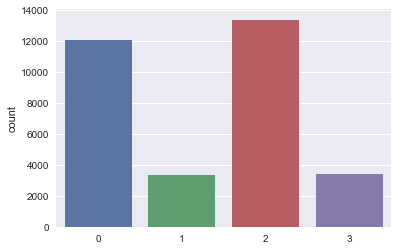

In [185]:
# Extract the lables from the last characters in the filename
labels = []
for i in image_filenames:
    l = i[-6:-5]
    labels.append(int(l))
        
# Count the number of clases
num_classes = len(set(labels))

# convert to binary encoded labels
labels_wide = keras.utils.to_categorical(labels, num_classes)
# Plot a bar plot of the labels
sns.countplot(labels)

### Partition the dataset for evaluation
Split the data into a training (80%) and test (20%) partition so we can evaluate at the end

In [186]:
train, test, train_labels, test_labels = train_test_split(data, labels, random_state=0, test_size = 0.2, train_size = 0.8)
train_labels_wide = keras.utils.to_categorical(train_labels, num_classes)
test_labels_wide = keras.utils.to_categorical(test_labels, num_classes)

Apply under sampling to balance the training dataset

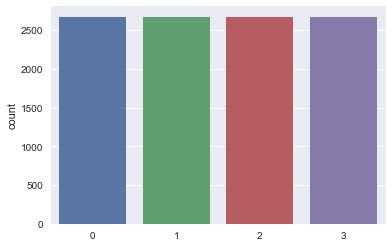

In [187]:
# Apply the random under-sampling
rus = RandomUnderSampler(return_indices=True)
train_rus, train_labels_rus, idx_resampled = rus.fit_sample(train.reshape(len(train), ROWS*COLS*CHANNELS), train_labels)
train_rus, train_labels_rus = shuffle(train_rus, train_labels_rus)
train_rus = train_rus.reshape(len(train_rus), CHANNELS,ROWS, COLS)
sns.countplot(train_labels_rus)
train_labels_rus_wide = keras.utils.to_categorical(train_labels_rus, num_classes)


## CNN Models

### Model 1 : Basic model with one convolutional layer

Define the model

In [169]:
model = Sequential()
# First convolutional layer
model.add(Conv2D(32, (3, 3), padding='same', input_shape=(CHANNELS, ROWS, COLS), activation='relu', data_format="channels_first"))
# First Max pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten
model.add(Flatten())

# Dense layer
model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.5))

model.add(Dense(num_classes, activation = 'softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_89 (Conv2D)           (None, 32, 84, 84)        320       
_________________________________________________________________
max_pooling2d_75 (MaxPooling (None, 16, 42, 84)        0         
_________________________________________________________________
flatten_26 (Flatten)         (None, 56448)             0         
_________________________________________________________________
dense_52 (Dense)             (None, 128)               7225472   
_________________________________________________________________
dense_53 (Dense)             (None, 4)                 516       
Total params: 7,226,308
Trainable params: 7,226,308
Non-trainable params: 0
_________________________________________________________________


Compile and run the model using categorical_crossentropy as loss and Adam as optimizer

In [170]:
model.compile(loss='categorical_crossentropy', optimizer=adam(lr=1e-3), metrics=['accuracy'])
epochs = 50
batch_size = 128
history = model.fit(train_rus, train_labels_rus_wide, batch_size=batch_size, epochs=epochs, validation_split=0.25, verbose=1, shuffle=True)

Train on 1626 samples, validate on 542 samples
Epoch 1/50
1626/1626 [==============================] - 29s 18ms/step - loss: 3.1703 - acc: 0.2552 - val_loss: 1.4465 - val_acc: 0.2122
Epoch 2/50
1626/1626 [==============================] - 26s 16ms/step - loss: 1.3996 - acc: 0.3057 - val_loss: 1.3597 - val_acc: 0.3469
Epoch 3/50
1626/1626 [==============================] - 28s 17ms/step - loss: 1.3000 - acc: 0.4090 - val_loss: 1.3458 - val_acc: 0.3542
Epoch 4/50
1626/1626 [==============================] - 27s 17ms/step - loss: 1.2430 - acc: 0.4674 - val_loss: 1.2628 - val_acc: 0.4465
Epoch 5/50
1626/1626 [==============================] - 28s 17ms/step - loss: 1.1823 - acc: 0.5178 - val_loss: 1.2312 - val_acc: 0.4502
Epoch 6/50
1626/1626 [==============================] - 27s 17ms/step - loss: 1.1464 - acc: 0.5062 - val_loss: 1.2141 - val_acc: 0.4446
Epoch 7/50
1626/1626 [==============================] - 28s 17ms/step - loss: 1.0762 - acc: 0.5498 - val_loss: 1.1758 - val_acc: 0.4815
E

### Model 2 : 3 Convolution layers with MaxPooling and dropout after each layer

Define the model

In [188]:
# output: loss: 0.0569 - acc: 0.9786 - val_loss: 3.5705 - val_acc: 0.4358
model = Sequential()
# First convolutional layer
model.add(Conv2D(32, (8, 8), strides=(4, 4), padding='same', input_shape=(CHANNELS, ROWS, COLS),data_format="channels_first", activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))

# Second convolutional layer
model.add(Conv2D(64, (4, 4), strides=(2, 2), activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))

# Third convolutional layer
model.add(Conv2D(64, (3, 3), strides=(1, 1), activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))
#Flatten layer
model.add(Flatten())

# dense layer
model.add(Dense(512, activation='relu'))
# 50% dropout
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation = 'softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_93 (Conv2D)           (None, 32, 21, 21)        2080      
_________________________________________________________________
dropout_71 (Dropout)         (None, 32, 21, 21)        0         
_________________________________________________________________
max_pooling2d_79 (MaxPooling (None, 31, 20, 21)        0         
_________________________________________________________________
conv2d_94 (Conv2D)           (None, 14, 9, 64)         21568     
_________________________________________________________________
dropout_72 (Dropout)         (None, 14, 9, 64)         0         
_________________________________________________________________
max_pooling2d_80 (MaxPooling (None, 13, 8, 64)         0         
_________________________________________________________________
conv2d_95 (Conv2D)           (None, 11, 6, 64)         36928     
__________

### :: NOTE :: Detailed Comparison of both the CNN model architectures has been provided in the notebook named "*Analysis and Experimentation*"

Compile the model

In [189]:
model.compile(loss='categorical_crossentropy', optimizer=adam(lr=1e-3), metrics=['accuracy'])

Run the model

In [190]:
epochs = 50
batch_size = 128
start_time = time.time()
history = model.fit(train_rus, train_labels_rus_wide, batch_size=batch_size, epochs=epochs, validation_split=0.25, verbose=1, shuffle=True)
end_time = time.time()

Train on 8013 samples, validate on 2671 samples
Epoch 1/50
8013/8013 [==============================] - 26s 3ms/step - loss: 1.4028 - acc: 0.2694 - val_loss: 1.3556 - val_acc: 0.3841
Epoch 2/50
8013/8013 [==============================] - 24s 3ms/step - loss: 1.2379 - acc: 0.3942 - val_loss: 1.2235 - val_acc: 0.4354
Epoch 3/50
8013/8013 [==============================] - 26s 3ms/step - loss: 1.1338 - acc: 0.4483 - val_loss: 1.1628 - val_acc: 0.4830
Epoch 4/50
8013/8013 [==============================] - 25s 3ms/step - loss: 1.0818 - acc: 0.4827 - val_loss: 1.1416 - val_acc: 0.4901
Epoch 5/50
8013/8013 [==============================] - 25s 3ms/step - loss: 1.0610 - acc: 0.4988 - val_loss: 1.1217 - val_acc: 0.5028
Epoch 6/50
8013/8013 [==============================] - 25s 3ms/step - loss: 1.0421 - acc: 0.4986 - val_loss: 1.0943 - val_acc: 0.5110
Epoch 7/50
8013/8013 [==============================] - 24s 3ms/step - loss: 1.0415 - acc: 0.4981 - val_loss: 1.0970 - val_acc: 0.5032
Epoch 8

Print the time taken to train the model

In [116]:
print("The time taken to train the CNN model with 50 percent dataset containing 84x84 dimension images is : %.2f seconds" % (end_time - start_time))

The time taken to train the CNN model with 50 percent dataset containing 84x84 dimension images is : 1271.88 seconds


Plot the evolution of the loss and accuracy as the model was trained.

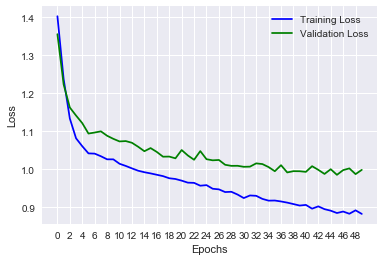

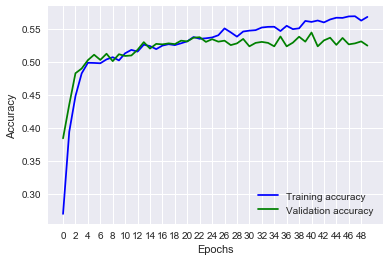

In [191]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0,epochs)[0::2])
plt.legend()
plt.show()

acc = history.history['acc']
val_acc = history.history['val_acc']
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(acc, 'blue', label='Training accuracy')
plt.plot(val_acc, 'green', label='Validation accuracy')
plt.xticks(range(0,50)[0::2])
plt.legend()
plt.show()

We observe that the training loss starts decreasing at a higher rate than the validation loss. The validation loss becomes stable after ~35 epochs, and that is when the model has found the minimum loss and becomes stable after that. Overall validation accuracy is ~50%. The training and validation accuracy are moslty aligned together, proving that there is no overfitting present in the model.

### Evaluation experiment on the Model
Use the test dataset to evaluate the model

In [120]:
print("****** Test Data ********")
# Make a set of predictions for the validation data
y_pred = model.predict_classes(test)
print("Accuracy of the CNN model on the test set is : %.3f\n" % accuracy_score(y_pred, test_labels))

# Print performance details
print("Classification report of CNN : \n", metrics.classification_report(test_labels, y_pred))

# Print confusion matrix
print("************* Confusion Matrix ********** ")
pd.crosstab(np.array(test_labels), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

****** Test Data ********
Accuracy of the CNN model on the test set is : 0.440

Classification report of CNN : 
              precision    recall  f1-score   support

          0       0.45      0.45      0.45      2420
          1       0.61      0.59      0.60       674
          2       0.50      0.32      0.39      2678
          3       0.30      0.75      0.43       661

avg / total       0.47      0.44      0.44      6433

************* Confusion Matrix ********** 


Predicted,0,1,2,3,All
True,,,,,
0,1082,123,686,529,2420
1,143,400,114,17,674
2,1067,132,850,629,2678
3,102,1,61,497,661
All,2394,656,1711,1672,6433


### Persist the Model
####  Since we observe that highest accuracy and lowest loss is in the Second CNN model, we  persist the model for future use, without having to retrain it.
Save the model

In [119]:
filepath = "player_images_2.mod"
model.save(filepath)